# Multilayer QG

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import einops
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float

from jaxsw._src.domain.base import Domain
from jaxsw._src.operators.functional import advection as F_adv
from jaxsw._src.operators.functional import geostrophic as F_geos
from jaxsw._src.operators.functional import cgrid as F_cgrid
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz
from jaxsw._src.models import qg_louis as F_qgml

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/eman/miniconda3/envs/jaxsw/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
from loguru import logger


def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 3))

    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i], cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    logger.debug(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


$$
\partial_t q_k + (u_kq_k)_x + (v_kq_k)_y = F_k + D_k
$$ (eq:qg_form_adv)

The term that links each of the layers together, $\mathbf{A}$, is a tri-diagonal matrix that can be written as

$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_2'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In the paper [[Thiry et al., 2023](https://doi.org/10.22541/essoar.167397445.54992823/v1)], they use the following method

$$
\begin{aligned}
\text{Hyperviscosity}: && 
\boldsymbol{D_1} &= 
-a_4\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Domain

In [3]:
import typing as tp

params = F_qgml.PDEParams()

In [4]:
# Low Resolution
Nx, Ny = 97, 121
# High Resolution
Lx, Ly = 3840.0e3, 4800.0e3

# initialize domain
# domain = Domain.from_numpoints(xmin=(0, 0), xmax=(Lx, Ly), N=(Nx+1, Ny+1))
domain = F_qgml.Domain(nx=Nx, ny=Ny, Lx=Lx, Ly=Ly)

domain.dx

40000.0

### Heights


$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_2'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In [5]:
# heights
heights = [350.0, 750.0, 2900.0]

num_heights = len(heights)

# reduced gravities
reduced_gravities = [0.025, 0.0125]

A_mat = F_qgml.MLQGHeightMatrix(heights, reduced_gravities)

A_mat()

Array([[ 0.11428571, -0.11428571,  0.        ],
       [-0.05333333,  0.16      , -0.10666667],
       [ 0.        , -0.02758621,  0.02758621]], dtype=float64)

In [6]:
A_mat.lambd, A_mat.A_layer_2_mode, A_mat.A_mode_2_layer

(Array([ 2.28183707e-01,  7.36882145e-02, -4.04361683e-18], dtype=float64),
 Array([[-0.43193138,  0.92242719, -0.49049581],
        [-0.65802762, -0.50089268,  1.15892029],
        [-0.15155445, -0.32475953, -1.25573684]], dtype=float64),
 Array([[-0.70499319, -0.92396019, -0.57735027],
        [ 0.70260146, -0.32821664, -0.57735027],
        [-0.09662189,  0.19639605, -0.57735027]], dtype=float64))

### Helmholtz Matrices

We can precompute the Helmoltz matrices

$$
\text{Helmholtz}:=\left(\alpha\boldsymbol{\nabla}-\beta\right)u
$$

In [7]:
from jaxsw._src.operators.functional import elliptical as F_elliptical

In [8]:
# compute Laplacian Matrix from DST
alpha = 1 / params.f0**2
beta = einops.repeat(A_mat.lambd, "Nz -> Nz 1 1")
# mean = True
# laplace_dst = alpha * F_elliptical.laplacian_dst(nx=domain.size[0], ny=domain.size[1], dx=domain.dx[0], dy=domain.dx[1], mean=mean)
# print_debug_quantity(laplace_dst)

# helmoltz_dst_mat = laplace_dst  - beta


# print_debug_quantity(helmoltz_dst_mat[0])
# print_debug_quantity(helmoltz_dst_mat[1])
# print_debug_quantity(helmoltz_dst_mat[2])
helmoltz_dst_mat = F_elliptical.helmholtz_dst(
    nx=domain.nx, ny=domain.ny, dx=domain.dx, dy=domain.dy, alpha=alpha, beta=beta
)
print_debug_quantity(helmoltz_dst_mat[0])
print_debug_quantity(helmoltz_dst_mat[1])
print_debug_quantity(helmoltz_dst_mat[2])

2023-07-12 00:12:57.108 | DEBUG    | __main__:print_debug_quantity:20 - : (95, 119) | -7.969477e-01 | -5.126282e-01 | -5.126282e-01 | -2.283086e-01
2023-07-12 00:12:57.110 | DEBUG    | __main__:print_debug_quantity:20 - : (95, 119) | -6.424522e-01 | -3.581327e-01 | -3.581327e-01 | -7.381310e-02
2023-07-12 00:12:57.111 | DEBUG    | __main__:print_debug_quantity:20 - : (95, 119) | -5.687640e-01 | -2.844445e-01 | -2.844445e-01 | -1.248847e-04


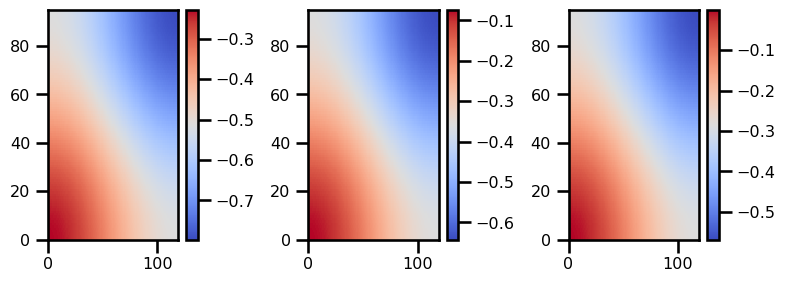

In [9]:
plot_field(helmoltz_dst_mat)

### Inversion

In [10]:
# # constant field
# constant_field = jnp.ones((A_mat.Nz, domain.size[0], domain.size[1])) / (domain.size[0] * domain.size[1])
# print_debug_quantity(constant_field)
# #
# s_solutions = jnp.zeros_like(constant_field)
# out = jax.vmap(F_elliptical.inverse_elliptic_dst, in_axes=(0,0))(constant_field[:, 1:-1,1:-1], helmoltz_dst_mat)
# s_solutions = s_solutions.at[:, 1:-1, 1:-1].set(out)
# print_debug_quantity(s_solutions[0])
# print_debug_quantity(s_solutions[1])
# print_debug_quantity(s_solutions[2])

# # homogeneous solution
# # ignore last solution correponding to lambd = 0, i.e. Laplace equation
# homogeneous_sol = (constant_field + s_solutions * beta)[:-1]

# print_debug_quantity(homogeneous_sol)

In [11]:
homogeneous_sol = F_qgml.homogeneous_sol_layers(helmoltz_dst_mat, domain, A_mat)
print_debug_quantity(homogeneous_sol)

2023-07-12 00:12:57.681 | DEBUG    | __main__:print_debug_quantity:20 - : (2, 97, 121) | -3.576361e-12 | 4.449322e-06 | 4.449322e-06 | 8.520065e-05


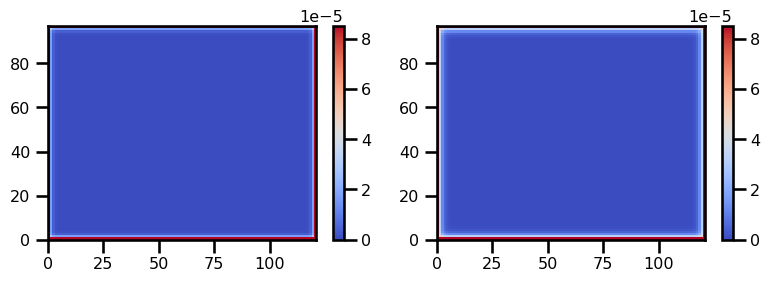

In [12]:
plot_field(homogeneous_sol)

### Alpha Matrix

In [13]:
alpha_matrix = F_qgml.compute_alpha_matrix(A_mat.A_mode_2_layer, homogeneous_sol)

print_debug_quantity(alpha_matrix)

2023-07-12 00:12:58.100 | DEBUG    | __main__:print_debug_quantity:20 - : (2, 2) | -2.558977e+05 | -1.140663e+05 | -1.140663e+05 | 2.813377e-11


## Forcing

In [14]:
# def init_tau(domain, tau0: float=2.0e-5):
#     """
#     Args
#     ----
#         tau0 (float): wind stress magnitude m/s^2
#             default=2.0e-5"""
#     # initial TAU
#     tau = np.zeros((2, domain.nx, domain.ny))

#     # create staggered coordinates (y-direction)
#     y_coords = np.arange(domain.ny) + 0.5

#     # create tau
#     tau[0, :, :] = - tau0 * np.cos(2 * np.pi * (y_coords / domain.ny))

#     return tau

# def calculate_wind_forcing(tau, domain):
#     # move from edges to nodes
#     tau_x = F_grid.x_average_2D(tau[0])
#     tau_y = F_grid.y_average_2D(tau[1])

#     # calculate curl
#     dF2dX = (tau_y[1:] - tau_y[:-1]) / domain.dx
#     dF1dY = (tau_x[:,1:] - tau_x[:,:-1]) / domain.dy
#     curl_stagg = dF2dX - dF1dY

#     # move from nodes to faces
#     return F_grid.center_average_2D(curl_stagg)

tau = F_qgml.init_tau(domain, tau0=2.0e-5)
print_debug_quantity(tau, "Tau")
wind_forcing = F_qgml.calculate_wind_forcing(tau, domain) / (params.f0 * heights[0])
print_debug_quantity(wind_forcing, "wind_forcing")

2023-07-12 00:13:05.387 | DEBUG    | __main__:print_debug_quantity:20 - Tau: (2, 97, 121) | -1.999326e-05 | 3.348584e-22 | 3.348584e-22 | 2.000000e-05
2023-07-12 00:13:05.835 | DEBUG    | __main__:print_debug_quantity:20 - wind_forcing: (95, 119) | -7.908487e-10 | -9.833974e-26 | -9.833974e-26 | 7.908487e-10


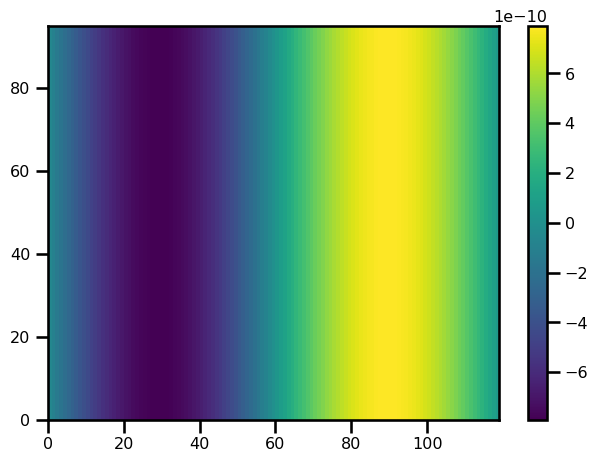

In [15]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(wind_forcing)
plt.colorbar(pts)

plt.tight_layout()
plt.show()

## Vorticity

In [16]:
# lap_fn = lambda x: fdx.laplacian(x, step_size=domain.dx, accuracy=1, method="central")
# lap_p = jax.vmap(lap_fn)(p)
# print_debug_quantity(lap_p, "LAPLACIAN")
# lap_p_ = laplacian(p, params.zfbc) / (domain.dx**2)
# print_debug_quantity(lap_p_, "LAPLACIAN")

In [17]:
# plot_field(lap_p)
# plot_field(lap_p_)
# plot_field(np.abs(lap_p_ - lap_p))

In [18]:
# lap_fn = lambda x: fdx.laplacian(x, step_size=domain.dx, accuracy=1, method="central")
# lap_p = jax.vmap(lap_fn)(p)
# bcs = F_qgml.laplacian_boundaries(lap_p, params.zfbc / (domain.dx**2))
# lap_p = F_qgml._apply_boundaries(lap_p, bcs)
# print_debug_quantity(lap_p, "LAPLACIAN")
# lap_p_ = laplacian(p, params.zfbc)
# lap_p_ = lap_p_ / (domain.dx**2)
# print_debug_quantity(lap_p_, "LAPLACIAN")

In [19]:
# plot_field(lap_p)
# plot_field(lap_p_)
# plot_field(np.abs(lap_p_ - lap_p))

In [20]:
p = np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
print_debug_quantity(p, "PRESSURE")
q = F_qgml.pressure_to_vorticity(p, A_mat(), domain, params)
print_debug_quantity(q, "VORTICITY")

2023-07-12 00:13:08.118 | DEBUG    | __main__:print_debug_quantity:20 - PRESSURE: (3, 97, 121) | -4.332182e+00 | 3.335592e-02 | 3.335592e-02 | 3.561408e+00
2023-07-12 00:13:08.305 | DEBUG    | __main__:print_debug_quantity:20 - VORTICITY: (3, 97, 121) | -4.657202e-01 | -6.788409e-06 | -6.788409e-06 | 4.963626e-01


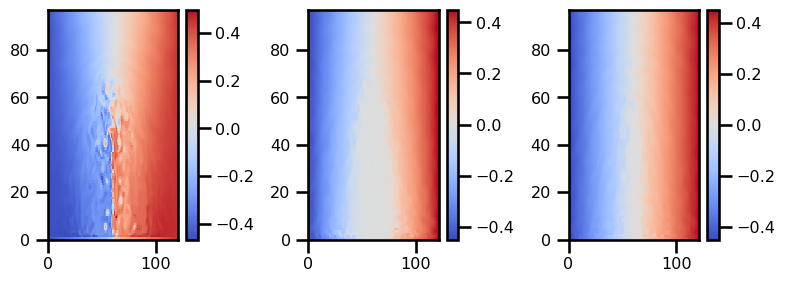

In [21]:
plot_field(q)

## RHS

### Determinant Jacobian

In [22]:
rhs = 1.0 / (params.f0 * domain.dx * domain.dy) * F_qgml.det_jacobian(q, p)
print_debug_quantity(rhs, "RHS DET JACOBIAN")

2023-07-12 00:13:09.665 | DEBUG    | __main__:print_debug_quantity:20 - RHS DET JACOBIAN: (3, 95, 119) | -1.564097e-06 | -1.405445e-12 | -1.405445e-12 | 1.195297e-06


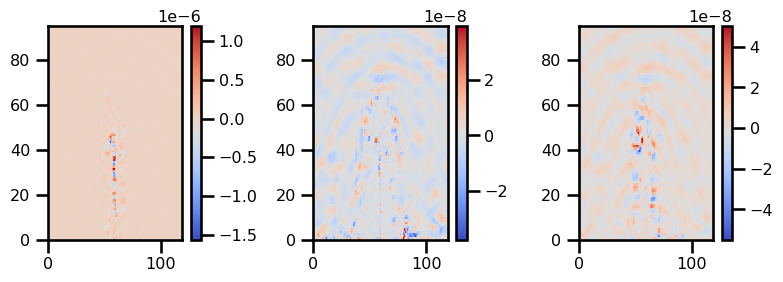

In [23]:
plot_field(rhs)

### Extra Terms

In [24]:
# def advection_term(p, params, domain):
#     return (1./ (params.f0 * domain.dx * domain.dy)) * F_qgml.det_jacobian(q, p)
# def diffusion_term(p, params, domain):
#     return params.a_2 / params.f0**2 / domain.dx**4 * F_qgml.laplacian_interior(p)

# def hyperdiffusion_term(p, params, domain):
#     return - (params.a_4 / params.f0**2) / domain.dx**6 * F_qgml.laplacian_interior(F_qgml.laplacian(p, params.zfbc))


# def bottom_friction(p, params, domain, height_params):
#     return params.delta_ek / (2*np.abs(params.f0)*domain.dx**2*(-height_params.heights[-1])) * F_qgml.laplacian_interior(p[...,-1:,:,:])

In [25]:
# p_diff = p

# # calculate
# delta2_p = F_qgml.laplacian(p_diff, params.zfbc)
# print_debug_quantity(delta2_p, "Laplacian Term")
# if params.a_2 != 0.:
#     diff_term = diffusion_term(delta2_p, params, domain)
#     print_debug_quantity(diff_term, "Diffusion Term")
#     rhs += diff_term
# if params.a_4 != 0.:
#     hyperdiff_term = hyperdiffusion_term(delta2_p, params, domain)
#     print_debug_quantity(hyperdiff_term, "Diffusion Term")
#     rhs += hyperdiff_term

# print_debug_quantity(wind_forcing, "WIND FORCING")
# rhs = rhs.at[...,0:1,:,:].set(rhs[...,0:1,:,:] + wind_forcing)
# bottom_term = bottom_friction(p, params, domain, A_mat)
# print_debug_quantity(bottom_term, "Bottom Friction")
# rhs = rhs.at[...,-1:,:,:].set(rhs[...,-1:,:,:]  + bottom_term)

### Full RHS

In [26]:
# def rhs_pde(q, p, params, domain):

#     # Calculate Determinant Jacobian
#     rhs = advection_term(p, params, domain)

#     # calculate Laplacian
#     delta2_p = F_qgml.laplacian(p, params.zfbc)

#     # Add Diffusion Term
#     if params.a_2 != 0.:
#         rhs += diffusion_term(delta2_p, params, domain)

#     # Add HyperDiffusion
#     if params.a_4 != 0.:
#         rhs += hyperdiffusion_term(delta2_p, params, domain)

#     # Add Wind Forcing
#     rhs = rhs.at[...,0:1,:,:].set(rhs[...,0:1,:,:] + wind_forcing)

#     # Add Bottom Friction
#     rhs = rhs.at[...,-1:,:,:].set(rhs[...,-1:,:,:]  + bottom_term)

#     return rhs

In [27]:
rhs = F_qgml.rhs_pde(q, p, params, domain, A_mat, wind_forcing)
print_debug_quantity(rhs, "RHS")

2023-07-12 00:13:11.639 | DEBUG    | __main__:print_debug_quantity:20 - RHS: (3, 95, 119) | -1.502200e-06 | -6.166340e-12 | -6.166340e-12 | 1.339342e-06


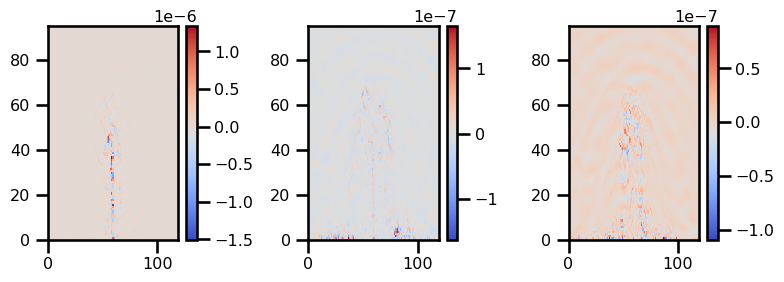

In [28]:
plot_field(rhs)

In [29]:
import functools as ft

rhs_fn = ft.partial(
    F_qgml.rhs_pde, params=params, domain=domain, A_mat=A_mat, wind_forcing=wind_forcing
)
rhs_jitted = jax.jit(rhs_fn)

In [30]:
%timeit out = rhs_fn(q, p)
%timeit out = rhs_jitted(q, p)

17 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
138 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
rhs_fn(q, p).shape

(3, 95, 119)

In [32]:
def rhs_time_step(q, p, params, A_mat, domain):
    # calculate advection - interior only
    dq_f0 = rhs_pde(q, p, params, domain)
    # pad - original domain
    dq_f0 = jnp.pad(dq_f0, ((0, 0), (1, 1), (1, 1)))

    # pressure
    rhs_helmholtz = jnp.einsum("ij,jkl->ikl", A_mat.A_layer_2_mode, dq_f0)
    dp_modes = jax.vmap(F_elliptical.inverse_elliptic_dst, in_axes=(0, 0))(
        rhs_helmholtz[:, 1:-1, 1:-1], helmoltz_dst_mat
    )
    # pad - original domain
    dp_modes = jnp.pad(dp_modes, ((0, 0), (1, 1), (1, 1)))

    # ensure mass conservation
    dalpha = alpha_matrix @ dp_modes[..., :-1, :, :].mean((-2, -1))
    dalpha = einops.repeat(dalpha, "i -> i 1 1")
    dp_modes = dp_modes.at[..., :-1, :, :].set(
        dp_modes[..., :-1, :, :] + dalpha * homogeneous_sol
    )
    dp = jnp.einsum("ij,jkl->ikl", A_mat.A_mode_2_layer, dp_modes)

    # UPDATE VORTICITY @ BOUNDARIES
    delta_p_boundaries = F_qgml.laplacian_boundaries(
        dp / (params.f0 * domain.dx) ** 2, params.zfbc
    )
    dp_boundaries = jnp.concatenate(
        [dp[..., 0, 1:-1], dp[..., -1, 1:-1], dp[..., :, 0], dp[..., :, -1]], axis=-1
    )
    dq_f0_boundaries = delta_p_boundaries - A_mat.A @ dp_boundaries

    dq_f0 = F_qgml._apply_boundaries(dq_f0, dq_f0_boundaries)

    return dq_f0, dp


args = F_qgml.QGARGS(
    A_mat=A_mat,
    domain=domain,
    wind_forcing=wind_forcing,
    helmoltz_dst=helmoltz_dst_mat,
    alpha_matrix=alpha_matrix,
    homogeneous_sol=homogeneous_sol,
)
dq_f0, dp = F_qgml.rhs_time_step(q, p, params=params, args=args)
print_debug_quantity(dp, "dp")
print_debug_quantity(dq_f0, "dq_f0")

2023-07-12 00:13:38.556 | DEBUG    | __main__:print_debug_quantity:20 - dp: (3, 97, 121) | -5.169436e-06 | 2.948032e-08 | 2.948032e-08 | 5.236780e-06
2023-07-12 00:13:38.556 | DEBUG    | __main__:print_debug_quantity:20 - dq_f0: (3, 97, 121) | -1.502200e-06 | -8.475099e-12 | -8.475099e-12 | 1.339342e-06


In [33]:
rhs_time_step_jitted = jax.jit(F_qgml.rhs_time_step, static_argnames=("params", "args"))


# vector field
def vector_field(t, state, args):
    q, p = state

    q, p = rhs_time_step_jitted(q, p, params, args)

    return (q, p)


p = np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
print_debug_quantity(p, "PRESSURE")
q = F_qgml.pressure_to_vorticity(p, A_mat(), domain, params)
print_debug_quantity(q, "VORTICITY")

state = (q, p)
args = F_qgml.QGARGS(
    A_mat=A_mat,
    domain=domain,
    wind_forcing=wind_forcing,
    helmoltz_dst=helmoltz_dst_mat,
    alpha_matrix=alpha_matrix,
    homogeneous_sol=homogeneous_sol,
)

2023-07-12 00:13:38.583 | DEBUG    | __main__:print_debug_quantity:20 - PRESSURE: (3, 97, 121) | -4.332182e+00 | 3.335592e-02 | 3.335592e-02 | 3.561408e+00
2023-07-12 00:13:38.589 | DEBUG    | __main__:print_debug_quantity:20 - VORTICITY: (3, 97, 121) | -4.657202e-01 | -6.788409e-06 | -6.788409e-06 | 4.963626e-01


In [34]:
dq_f0, dp = vector_field(0, state, args)
print_debug_quantity(dp, "dp")
print_debug_quantity(dq_f0, "dq_f0")

2023-07-12 00:13:39.020 | DEBUG    | __main__:print_debug_quantity:20 - dp: (3, 97, 121) | -5.169436e-06 | 2.948032e-08 | 2.948032e-08 | 5.236780e-06
2023-07-12 00:13:39.021 | DEBUG    | __main__:print_debug_quantity:20 - dq_f0: (3, 97, 121) | -1.502200e-06 | -8.475099e-12 | -8.475099e-12 | 1.339342e-06


## Time Stepping

We're going to use the Heun method.
I'll also be using `diffrax` to handle the time stepping :)

In [35]:
dt = 1_200  # LR # 600 # HR
n_years = 2
n_days = 365
tmin = 0
tmax = pd.to_timedelta(n_years * n_days, unit="day").total_seconds()
ts = jnp.arange(tmin, tmax, dt)

In [36]:
len(ts)

52560

In [62]:
(dt * freq_log) / 60 / 60 / 12

27.777777777777775

In [37]:
state = (q, p)
args = F_qgml.QGARGS(
    A_mat=A_mat,
    domain=domain,
    wind_forcing=wind_forcing,
    helmoltz_dst=helmoltz_dst_mat,
    alpha_matrix=alpha_matrix,
    homogeneous_sol=homogeneous_sol,
)

solver = dfx.Heun()
solver_state = solver.init(
    terms=dfx.ODETerm(vector_field),
    t0=tmax,
    t1=tmin + dt,
    y0=state,
    args=args,
)

In [38]:
n_check = 2_000
freq_log = 1_000
n_check

2000

In [39]:
saved_states = dict(q=list(), p=list(), t=list())

solver_step = jax.jit(solver.step, static_argnames=("made_jump", "terms"))

with tqdm(ts) as pbar:
    for t in pbar:
        state, _, _, solver_state, _ = solver_step(
            terms=dfx.ODETerm(vector_field),
            t0=t,
            t1=t + dt,
            y0=state,
            args=args,
            solver_state=solver_state,
            made_jump=False,
        )

        msg1 = f"PRESSURE: {jnp.min(state[0]):.4e} | {jnp.max(state[0]):.4e}"
        msg2 = f"VORTICITY: {jnp.min(state[1]):.4e} | {jnp.max(state[1]):.4e}"
        pbar.set_description(msg1 + " - " + msg2)

        if t % (freq_log * dt) == 0:
            saved_states["q"].append(state[0])
            saved_states["p"].append(state[1])
            saved_states["t"].append(t)

  0%|          | 0/52560 [00:00<?, ?it/s]

In [40]:
len(saved_states["q"])

53

## Analysis

In [42]:
import xarray as xr


ds_results = xr.Dataset(
    data_vars={
        "q": (("time", "layer", "x", "y"), np.stack(saved_states["q"], axis=0)),
        "p": (("time", "layer", "x", "y"), np.stack(saved_states["p"], axis=0)),
    },
    coords={
        "time": (("time"), np.stack(saved_states["t"], axis=0)),
        "layer": (("layer"), np.arange(3)),
        "x": (("x"), np.arange(0, domain.Lx + 1, domain.dx)),
        "y": (("y"), np.arange(0, domain.Ly + 1, domain.dy)),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 53, layer: 3, x: 97, y: 121)
Coordinates:
  * time     (time) float64 0.0 1.2e+06 2.4e+06 ... 6e+07 6.12e+07 6.24e+07
  * layer    (layer) int64 0 1 2
  * x        (x) float64 0.0 4e+04 8e+04 1.2e+05 ... 3.76e+06 3.8e+06 3.84e+06
  * y        (y) float64 0.0 4e+04 8e+04 1.2e+05 ... 4.72e+06 4.76e+06 4.8e+06
Data variables:
    q        (time, layer, x, y) float64 -0.452 -0.4532 ... 0.4413 0.4489
    p        (time, layer, x, y) float64 0.009725 0.02492 ... 0.008548 0.00464

In [55]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_p_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.p.min())
    vmax = kwargs.pop("vmax", sub.p.max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(15, 10)

    ax = fig.subplots(ncols=3, nrows=2)

    for i in range(3):
        # NATL60
        pts = sub.p.isel(layer=i).plot.pcolormesh(
            ax=ax[0, i],
            cmap="viridis",
            add_colorbar=True,
            vmin=vmin,
            vmax=vmax,
            # **kwargs
        )

        loc = ticker.MaxNLocator(6)
        levels = loc.tick_values(vmin, vmax)
        sub.p.isel(layer=i).plot.contour(
            ax=ax[0, i],
            levels=levels,
            vmin=vmin,
            vmax=vmax,
            alpha=0.5,
            linewidths=1,
            cmap="black",
            linestyles=np.where(levels >= 0, "-", "--"),
        )

        # ax.set_aspect('equal')
        pts = ax[0, i].set(xlabel="x [m]", ylabel="y [m]", title=f"Layer {i}")

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.q.min())
    vmax = kwargs.pop("vmax", sub.q.max())
    cmap = kwargs.pop("cmap", "viridis")

    for i in range(3):
        # NATL60
        pts = sub.q.isel(layer=i).plot.pcolormesh(
            ax=ax[1, i],
            cmap="RdBu_r",
            add_colorbar=True,
            vmin=vmin,
            vmax=vmax,
            # **kwargs
        )

        loc = ticker.MaxNLocator(6)
        levels = loc.tick_values(vmin, vmax)
        sub.q.isel(layer=i).plot.contour(
            ax=ax[1, i],
            levels=levels,
            vmin=vmin,
            vmax=vmax,
            alpha=0.5,
            linewidths=1,
            cmap="black",
            linestyles=np.where(levels >= 0, "-", "--"),
        )

        # ax.set_aspect('equal')
        pts = ax[0, i].set(xlabel="x [m]", ylabel="y [m]", title=f"Layer {i}")
        plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_p_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_43607/2891895688.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_43607/2891895688.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_43607/2891895688.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_43607/2891895688.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


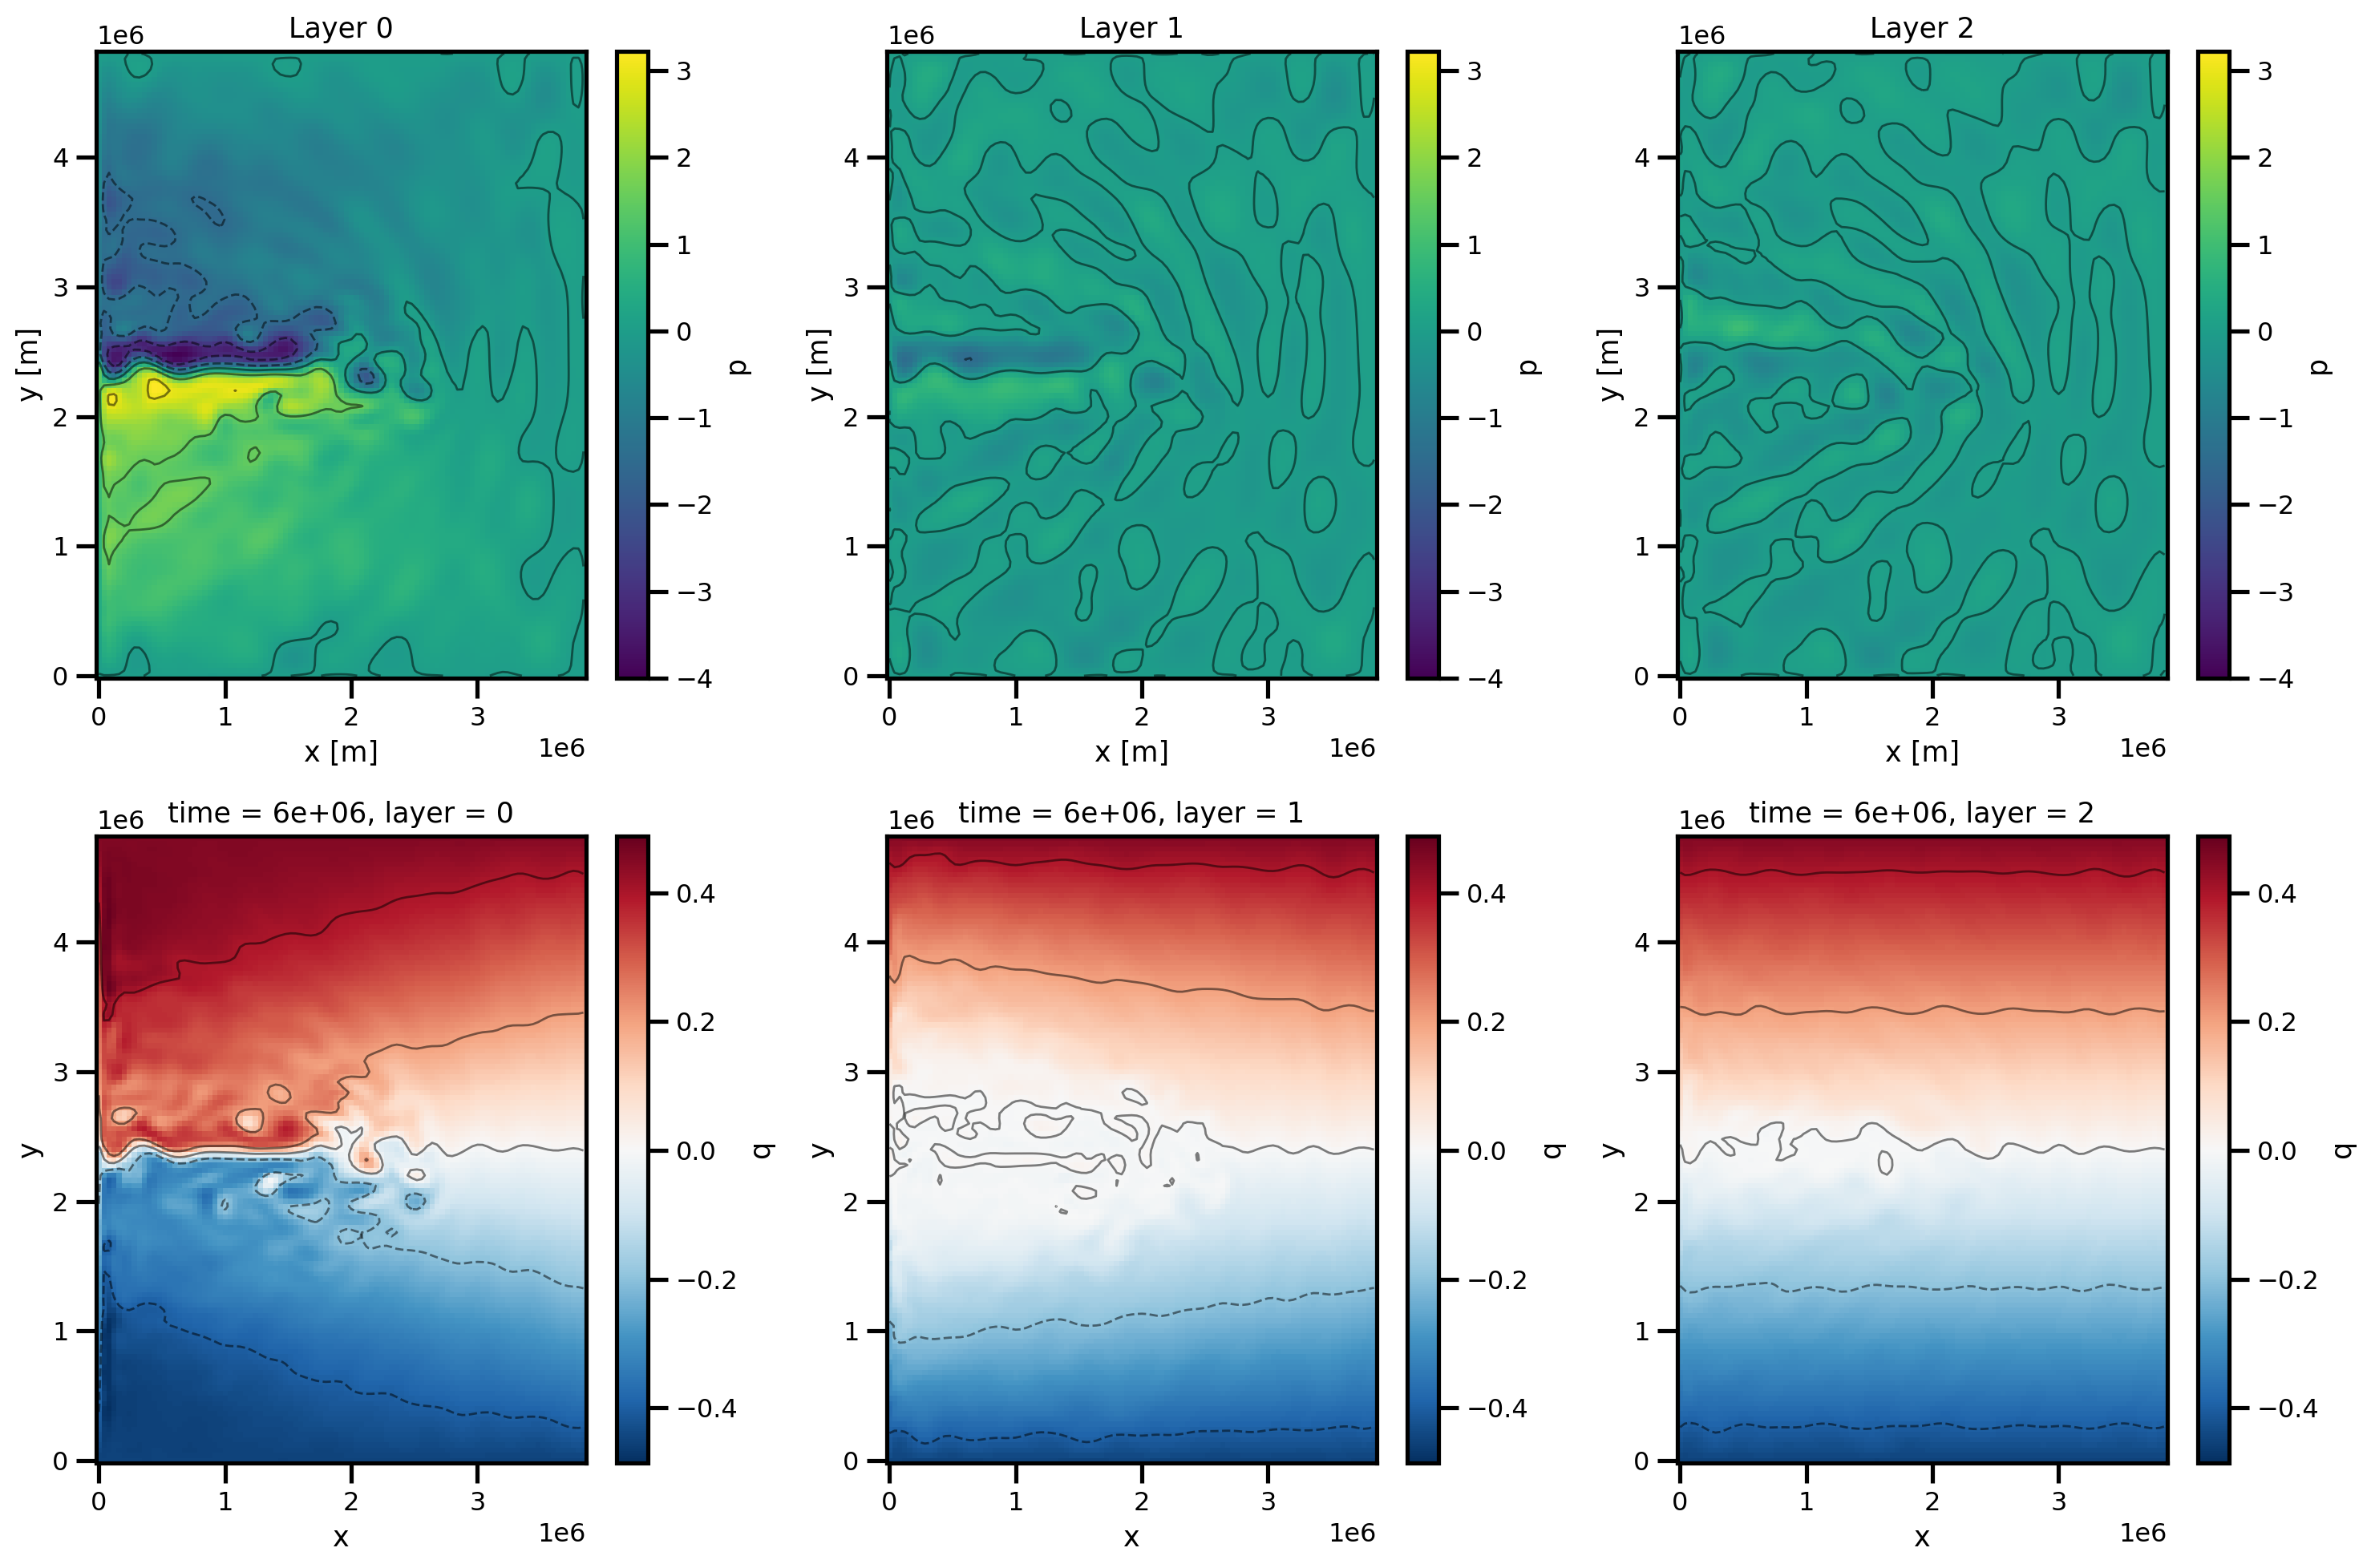

In [56]:
%matplotlib inline
mov = Movie(
    ds_results.transpose("time", "layer", "y", "x"),
    plotfunc=custom_plot_p_layers,
    framedim="time",
    input_check=False,
)
mov.preview(5)

In [45]:
ds_results.transpose("time", "layer", "y", "x").p.chunk({"time": 1})

<xarray.DataArray 'p' (time: 53, layer: 3, y: 121, x: 97)>
dask.array<xarray-<this-array>, shape=(53, 3, 121, 97), dtype=float64, chunksize=(1, 3, 121, 97), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 1.2e+06 2.4e+06 ... 6e+07 6.12e+07 6.24e+07
  * layer    (layer) int64 0 1 2
  * x        (x) float64 0.0 4e+04 8e+04 1.2e+05 ... 3.76e+06 3.8e+06 3.84e+06
  * y        (y) float64 0.0 4e+04 8e+04 1.2e+05 ... 4.72e+06 4.76e+06 4.8e+06

In [64]:
# create_movie(
#     ds_results.transpose("time", "layer", "y", "x"), #.sel(time=slice("2017-02-01", "2017-03-01")),
#     name="pressure_vorticity",
#     plotfunc=custom_plot_p_layers,
#     file_path="./",
#     framedim="time",
#     cmap="viridis",
#     robust=True,
# )